In [262]:
# Solar and Battery Analysis Notebook
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
sns.set_palette("husl")

# Data Loading and Preprocessing
def load_and_preprocess_data(file_path):
    """
    Load and preprocess the solar data CSV file
    """
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Convert Date and Time columns to datetime
    df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
    
    # Set datetime as index
    df.set_index('datetime', inplace=True)
    
    # Sort by datetime
    df.sort_index(inplace=True)
    
    return df

# 1. Night Time Analysis
def analyze_night_usage(df):
    """
    Analyze energy usage during nighttime (when PV = 0)
    """
    # Identify nighttime periods
    df['is_night'] = df['PV (W)'] == 0
    
    # Group by date
    daily_groups = df.groupby(df.index.date)
    
    night_stats = []
    for date, day_data in daily_groups:
        night_data = day_data[day_data['is_night']]
        
        stats = {
            'date': date,
            'night_hours': len(night_data) * 5 / 60,  # 5-minute intervals to hours
            'energy_usage_kwh': night_data['Load (W)'].sum() * 5 / 60 / 1000,
            'avg_load_w': night_data['Load (W)'].mean(),
            'peak_load_w': night_data['Load (W)'].max(),
            'min_load_w': night_data['Load (W)'].min()
        }
        night_stats.append(stats)
    
    return pd.DataFrame(night_stats)

def plot_night_usage(night_stats):
    """
    Create visualizations for nighttime usage patterns
    """
    fig, axes = plt.subplots(2, 1, figsize=(15, 12))
    
    # Plot 1: Night Energy Usage
    night_stats.plot(x='date', y='energy_usage_kwh', 
                    kind='bar', ax=axes[0],
                    title='Nightly Energy Usage')
    axes[0].set_xlabel('Date')
    axes[0].set_ylabel('Energy Usage (kWh)')
    axes[0].tick_params(axis='x', rotation=45)
    
    # Plot 2: Load Profile
    night_stats.plot(x='date', y=['avg_load_w', 'peak_load_w'], 
                    kind='line', ax=axes[1],
                    title='Nightly Load Profile')
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('Power (W)')
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    return fig

# 2. Battery Sizing Analysis
def analyze_battery_requirements(night_stats):
    """
    Calculate battery requirements based on nighttime usage
    """
    results = {
        'avg_night_usage_kwh': night_stats['energy_usage_kwh'].mean(),
        'max_night_usage_kwh': night_stats['energy_usage_kwh'].max(),
        'recommended_capacity_kwh': night_stats['energy_usage_kwh'].max() * 1.2,
        'avg_peak_load_w': night_stats['peak_load_w'].mean(),
        'max_peak_load_w': night_stats['peak_load_w'].max(),
        '95th_percentile_usage_kwh': night_stats['energy_usage_kwh'].quantile(0.95)
    }
    
    return pd.Series(results)

# 3. Solar Generation Analysis
def analyze_solar_generation(df):
    """
    Analyze solar generation patterns and capability
    """
    daily_solar = df.groupby(df.index.date).agg({
        'PV (W)': [
            ('total_kwh', lambda x: (x * 5/60).sum() / 1000),
            ('peak_w', 'max'),
            ('avg_w', 'mean')
        ]
    })
    
    daily_solar.columns = daily_solar.columns.droplevel()
    return daily_solar

def plot_solar_analysis(solar_stats):
    """
    Create visualizations for solar generation
    """
    fig, axes = plt.subplots(2, 1, figsize=(15, 12))
    
    # Plot 1: Daily Solar Generation
    solar_stats.plot(y='total_kwh', kind='bar', ax=axes[0],
                    title='Daily Solar Generation')
    axes[0].set_xlabel('Date')
    axes[0].set_ylabel('Energy Generated (kWh)')
    axes[0].tick_params(axis='x', rotation=45)
    
    # Plot 2: Peak vs Average Generation
    solar_stats.plot(y=['peak_w', 'avg_w'], kind='line', ax=axes[1],
                    title='Peak vs Average Solar Generation')
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('Power (W)')
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    return fig

# 4. Load Profile Analysis
def analyze_load_profile(df):
    """
    Analyze load profile patterns
    """
    # Calculate hourly averages
    hourly_avg = df.groupby(df.index.hour)['Load (W)'].agg([
        'mean', 'min', 'max', 'std'
    ])
    
    # Calculate daily patterns
    daily_patterns = df.groupby([df.index.hour, df.index.date])['Load (W)'].mean()
    daily_patterns = daily_patterns.unstack()
    
    return hourly_avg, daily_patterns

def plot_load_profile(hourly_avg, daily_patterns):
    """
    Create visualizations for load profile analysis
    """
    fig, axes = plt.subplots(2, 1, figsize=(15, 12))
    
    # Plot 1: Average Hourly Load
    hourly_avg.plot(y='mean', ax=axes[0],
                   title='Average Hourly Load Profile')
    axes[0].fill_between(hourly_avg.index,
                        hourly_avg['mean'] - hourly_avg['std'],
                        hourly_avg['mean'] + hourly_avg['std'],
                        alpha=0.2)
    axes[0].set_xlabel('Hour of Day')
    axes[0].set_ylabel('Power (W)')
    
    # Plot 2: Daily Load Heatmap
    sns.heatmap(daily_patterns, ax=axes[1],
                cmap='YlOrRd', cbar_kws={'label': 'Power (W)'})
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('Hour of Day')
    
    plt.tight_layout()
    return fig

# 5. Self-Sufficiency Analysis
def analyze_self_sufficiency(df):
    """
    Analyze potential for self-sufficiency
    """
    # Calculate energy balance for each interval
    df['solar_energy_wh'] = df['PV (W)'] * 5/60  # 5-minute intervals
    df['load_energy_wh'] = df['Load (W)'] * 5/60
    df['energy_balance_wh'] = df['solar_energy_wh'] - df['load_energy_wh']
    
    # Daily totals
    daily_balance = df.groupby(df.index.date).agg({
        'solar_energy_wh': 'sum',
        'load_energy_wh': 'sum',
        'energy_balance_wh': 'sum'
    }) / 1000  # Convert to kWh
    
    daily_balance['self_sufficiency_ratio'] = (
        daily_balance['solar_energy_wh'] / daily_balance['load_energy_wh']
    )
    
    return daily_balance

def plot_self_sufficiency(daily_balance):
    """
    Create visualizations for self-sufficiency analysis
    """
    fig, axes = plt.subplots(2, 1, figsize=(15, 12))
    
    # Plot 1: Daily Energy Balance
    daily_balance[['solar_energy_wh', 'load_energy_wh']].plot(
        kind='bar', ax=axes[0],
        title='Daily Energy Generation vs Usage')
    axes[0].set_xlabel('Date')
    axes[0].set_ylabel('Energy (kWh)')
    axes[0].tick_params(axis='x', rotation=45)
    
    # Plot 2: Self-Sufficiency Ratio
    daily_balance['self_sufficiency_ratio'].plot(
        kind='line', ax=axes[1],
        title='Daily Self-Sufficiency Ratio')
    axes[1].axhline(y=1, color='r', linestyle='--', label='100% Self-Sufficient')
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('Ratio')
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    return fig

# 6. Battery Performance Analysis
def analyze_battery_performance(df):
    """
    Analyze current battery performance and usage patterns
    """
    # Calculate battery metrics
    battery_metrics = df.groupby(df.index.date).agg({
        'Battery (W)': [
            ('max_charge', lambda x: x[x > 0].max() if len(x[x > 0]) > 0 else 0),
            ('max_discharge', lambda x: abs(x[x < 0].min()) if len(x[x < 0]) > 0 else 0),
            ('avg_charge', lambda x: x[x > 0].mean() if len(x[x > 0]) > 0 else 0),
            ('avg_discharge', lambda x: abs(x[x < 0].mean()) if len(x[x < 0]) > 0 else 0),
            ('charge_duration', lambda x: len(x[x > 0]) * 5 / 60),  # hours
            ('discharge_duration', lambda x: len(x[x < 0]) * 5 / 60)  # hours
        ],
        'SOC (%)': ['min', 'max', 'mean']
    })
    
    battery_metrics.columns = ['_'.join(col).strip() for col in battery_metrics.columns.values]
    return battery_metrics

def analyze_battery_deficit(df):
    """
    Analyze periods where battery capacity was insufficient
    """
    # Calculate energy deficit (when grid power is needed despite battery being available)
    df['deficit_w'] = df.apply(lambda row: row['Grid (W)'] if row['SOC (%)'] < 100 else 0, axis=1)
    
    daily_deficit = df.groupby(df.index.date).agg({
        'deficit_w': [
            ('total_deficit_kwh', lambda x: (x * 5/60).sum() / 1000),
            ('max_deficit_w', 'max'),
            ('avg_deficit_w', 'mean')
        ],
        'Grid (W)': [
            ('total_grid_kwh', lambda x: (x * 5/60).sum() / 1000)
        ]
    })
    
    daily_deficit.columns = ['_'.join(col).strip() for col in daily_deficit.columns.values]
    return daily_deficit

def calculate_flat_rate_battery_capacity(df, backup_hours=24, depth_of_discharge=0.8):
    """
    Calculate optimal battery capacity for flat rate electricity scenario
    
    Parameters:
    - df: DataFrame containing the energy data
    - backup_hours: Desired backup duration in hours (default 24)
    - depth_of_discharge: Maximum recommended battery discharge (default 0.8)
    
    Returns:
    - Dictionary containing capacity recommendations and load analysis
    """
    # Calculate average hourly energy needs
    df['load_energy_wh'] = df['Load (W)'] * 5/60  # 5-min intervals to Wh
    hourly_energy = df.groupby(df.index.hour)['load_energy_wh'].mean() * 12  # 12 5-min intervals per hour
    
    # Calculate required capacity
    avg_daily_load_kwh = hourly_energy.sum() / 1000
    required_capacity = {
        'avg_daily_load_kwh': avg_daily_load_kwh,
        'recommended_capacity_kwh': (avg_daily_load_kwh * (backup_hours/24)) / depth_of_discharge,
        'hourly_load_profile': hourly_energy / 1000  # Convert to kWh
    }
    
    return required_capacity

def analyze_solar_battery_economics(df, electricity_rate, battery_cost_per_kwh,
                                  battery_cycles=3500, backup_hours=24):
    """
    Analyze economics of battery storage with flat rate electricity
    
    Parameters:
    - df: DataFrame containing the energy data
    - electricity_rate: Flat electricity rate ($/kWh)
    - battery_cost_per_kwh: Battery system cost per kWh of capacity
    - battery_cycles: Expected battery lifecycle in cycles (default 3500)
    - backup_hours: Desired backup duration in hours (default 24)
    """
    # Calculate daily solar generation and load
    df['solar_energy_wh'] = df['PV (W)'] * 5/60
    df['load_energy_wh'] = df['Load (W)'] * 5/60
    
    daily_totals = df.groupby(df.index.date).agg({
        'solar_energy_wh': 'sum',
        'load_energy_wh': 'sum'
    }) / 1000  # Convert to kWh
    
    # Calculate storage needs
    avg_daily_load = daily_totals['load_energy_wh'].mean()
    recommended_capacity = avg_daily_load * (backup_hours/24) / 0.8  # Assuming 80% DoD
    
    # Economic analysis
    battery_cost = recommended_capacity * battery_cost_per_kwh
    daily_grid_energy = (daily_totals['load_energy_wh'] - daily_totals['solar_energy_wh']).clip(lower=0)
    annual_grid_cost = daily_grid_energy.mean() * 365 * electricity_rate
    
    economics = {
        'recommended_capacity_kwh': recommended_capacity,
        'estimated_battery_cost': battery_cost,
        'avg_daily_grid_energy_kwh': daily_grid_energy.mean(),
        'annual_grid_cost': annual_grid_cost,
        'battery_life_years': (battery_cycles / 365),
        'simple_payback_years': battery_cost / (annual_grid_cost if annual_grid_cost > 0 else float('inf'))
    }
    
    return economics

def plot_battery_analysis(df, battery_metrics, daily_deficit):
    """
    Create comprehensive visualizations for battery analysis
    """
    fig, axes = plt.subplots(3, 1, figsize=(15, 18))
    
    # Plot 1: Battery State of Charge Pattern
    df.groupby(df.index.hour)['SOC (%)'].mean().plot(
        kind='line', ax=axes[0],
        title='Average Battery State of Charge by Hour')
    axes[0].set_xlabel('Hour of Day')
    axes[0].set_ylabel('SOC (%)')
    
    # Plot 2: Daily Battery Usage Pattern
    battery_metrics[['Battery (W)_avg_charge', 'Battery (W)_avg_discharge']].plot(
        kind='bar', ax=axes[1],
        title='Daily Battery Charge/Discharge Pattern')
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('Power (W)')
    axes[1].tick_params(axis='x', rotation=45)
    
    # Plot 3: Grid Dependency
    daily_grid_usage = daily_deficit['Grid (W)_total_grid_kwh'].to_frame('Grid Usage (kWh)')
    daily_grid_usage.plot(
        kind='line', ax=axes[2],
        title='Daily Grid Usage')
    axes[2].set_xlabel('Date')
    axes[2].set_ylabel('Energy (kWh)')
    axes[2].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    return fig

# 7. System Efficiency Analysis
def analyze_system_efficiency(df):
    """
    Analyze the overall efficiency of the solar + battery system
    """
    # Calculate energy flows
    df['solar_energy_wh'] = df['PV (W)'] * 5/60  # 5-minute intervals
    df['battery_energy_wh'] = df['Battery (W)'] * 5/60
    df['grid_energy_wh'] = df['Grid (W)'] * 5/60
    df['load_energy_wh'] = df['Load (W)'] * 5/60
    
    # Daily totals
    daily_energy = df.groupby(df.index.date).agg({
        'solar_energy_wh': 'sum',
        'battery_energy_wh': lambda x: x[x > 0].sum(),  # Charging only
        'grid_energy_wh': 'sum',
        'load_energy_wh': 'sum'
    }) / 1000  # Convert to kWh
    
    # Calculate efficiency metrics
    daily_energy['solar_utilization'] = (
        daily_energy['solar_energy_wh'] / 
        (daily_energy['load_energy_wh'] + daily_energy['battery_energy_wh'])
    )
    daily_energy['grid_dependency'] = (
        daily_energy['grid_energy_wh'] / daily_energy['load_energy_wh']
    )
    
    # System performance metrics
    system_metrics = {
        'avg_solar_utilization': daily_energy['solar_utilization'].mean(),
        'avg_grid_dependency': daily_energy['grid_dependency'].mean(),
        'total_solar_kwh': daily_energy['solar_energy_wh'].sum(),
        'total_grid_kwh': daily_energy['grid_energy_wh'].sum(),
        'total_load_kwh': daily_energy['load_energy_wh'].sum(),
        'solar_contribution': (
            daily_energy['solar_energy_wh'].sum() / 
            daily_energy['load_energy_wh'].sum()
        )
    }
    
    return daily_energy, system_metrics

def plot_efficiency_analysis(daily_energy, system_metrics):
    """
    Create visualizations for system efficiency analysis
    """
    fig, axes = plt.subplots(2, 2, figsize=(20, 15))
    
    # Plot 1: Daily Energy Sources
    daily_sources = daily_energy[['solar_energy_wh', 'grid_energy_wh']]
    daily_sources.columns = ['Solar', 'Grid']
    daily_sources.plot(kind='bar', stacked=True, ax=axes[0, 0],
                      title='Daily Energy Sources')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('Energy (kWh)')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Plot 2: Solar Utilization
    daily_energy['solar_utilization'].plot(ax=axes[0, 1],
                                         title='Daily Solar Utilization Rate')
    axes[0, 1].set_xlabel('Date')
    axes[0, 1].set_ylabel('Utilization Rate')
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # Plot 3: Energy Flow Sankey
    try:
        import plotly.graph_objects as go
        
        # Prepare Sankey data
        label = ['Solar', 'Grid', 'Battery', 'Load']
        source = [0, 1, 0, 2]  # From nodes
        target = [2, 3, 3, 3]  # To nodes
        value = [
            system_metrics['total_solar_kwh'],
            system_metrics['total_grid_kwh'],
            daily_energy['battery_energy_wh'].sum(),
            system_metrics['total_load_kwh']
        ]
        
        # Create Sankey diagram
        fig_sankey = go.Figure(data=[go.Sankey(
            node=dict(pad=15, thickness=20, line=dict(color="black", width=0.5),
                     label=label, color="blue"),
            link=dict(source=source, target=target, value=value)
        )])
        fig_sankey.update_layout(title_text="Energy Flow Sankey Diagram")
        
    except ImportError:
        # Fallback to simple pie chart if plotly is not available
        energy_sources = pd.Series({
            'Solar': system_metrics['total_solar_kwh'],
            'Grid': system_metrics['total_grid_kwh']
        })
        energy_sources.plot(kind='pie', ax=axes[1, 0],
                          title='Total Energy Sources Distribution')
    
    # Plot 4: System Performance Metrics
    metrics_series = pd.Series({
        'Solar Utilization': system_metrics['avg_solar_utilization'],
        'Grid Dependency': system_metrics['avg_grid_dependency'],
        'Solar Contribution': system_metrics['solar_contribution']
    })
    metrics_series.plot(kind='bar', ax=axes[1, 1],
                       title='System Performance Metrics')
    axes[1, 1].set_ylabel('Ratio')
    
    plt.tight_layout()
    return fig

In [263]:
# Load the data
df = load_and_preprocess_data('solar_data.csv')

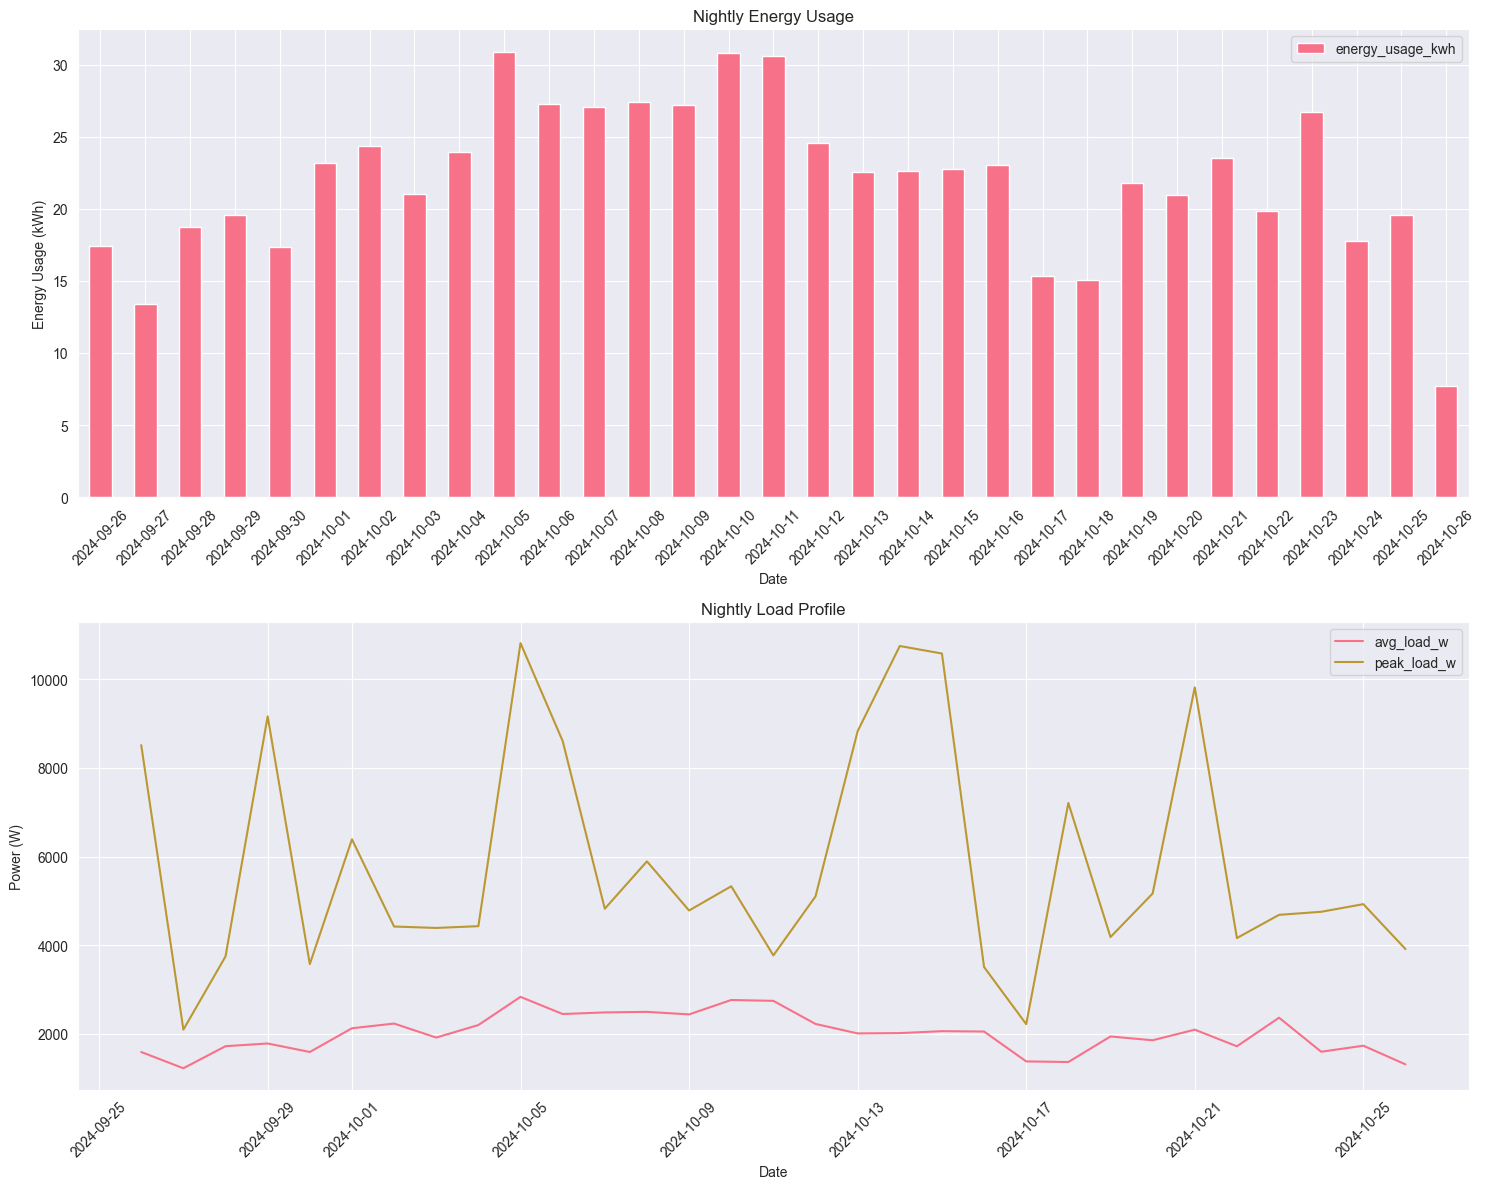

In [264]:
# 1. Night Time Analysis
night_stats = analyze_night_usage(df)
night_plot = plot_night_usage(night_stats)
plt.show()

In [265]:
# 2. Battery Requirements
battery_specs = analyze_battery_requirements(night_stats)
print("\nBattery Requirements:")
print(battery_specs)


Battery Requirements:
avg_night_usage_kwh             22.087454
max_night_usage_kwh             30.918667
recommended_capacity_kwh        37.102400
avg_peak_load_w               5823.387097
max_peak_load_w              10817.000000
95th_percentile_usage_kwh       30.728000
dtype: float64


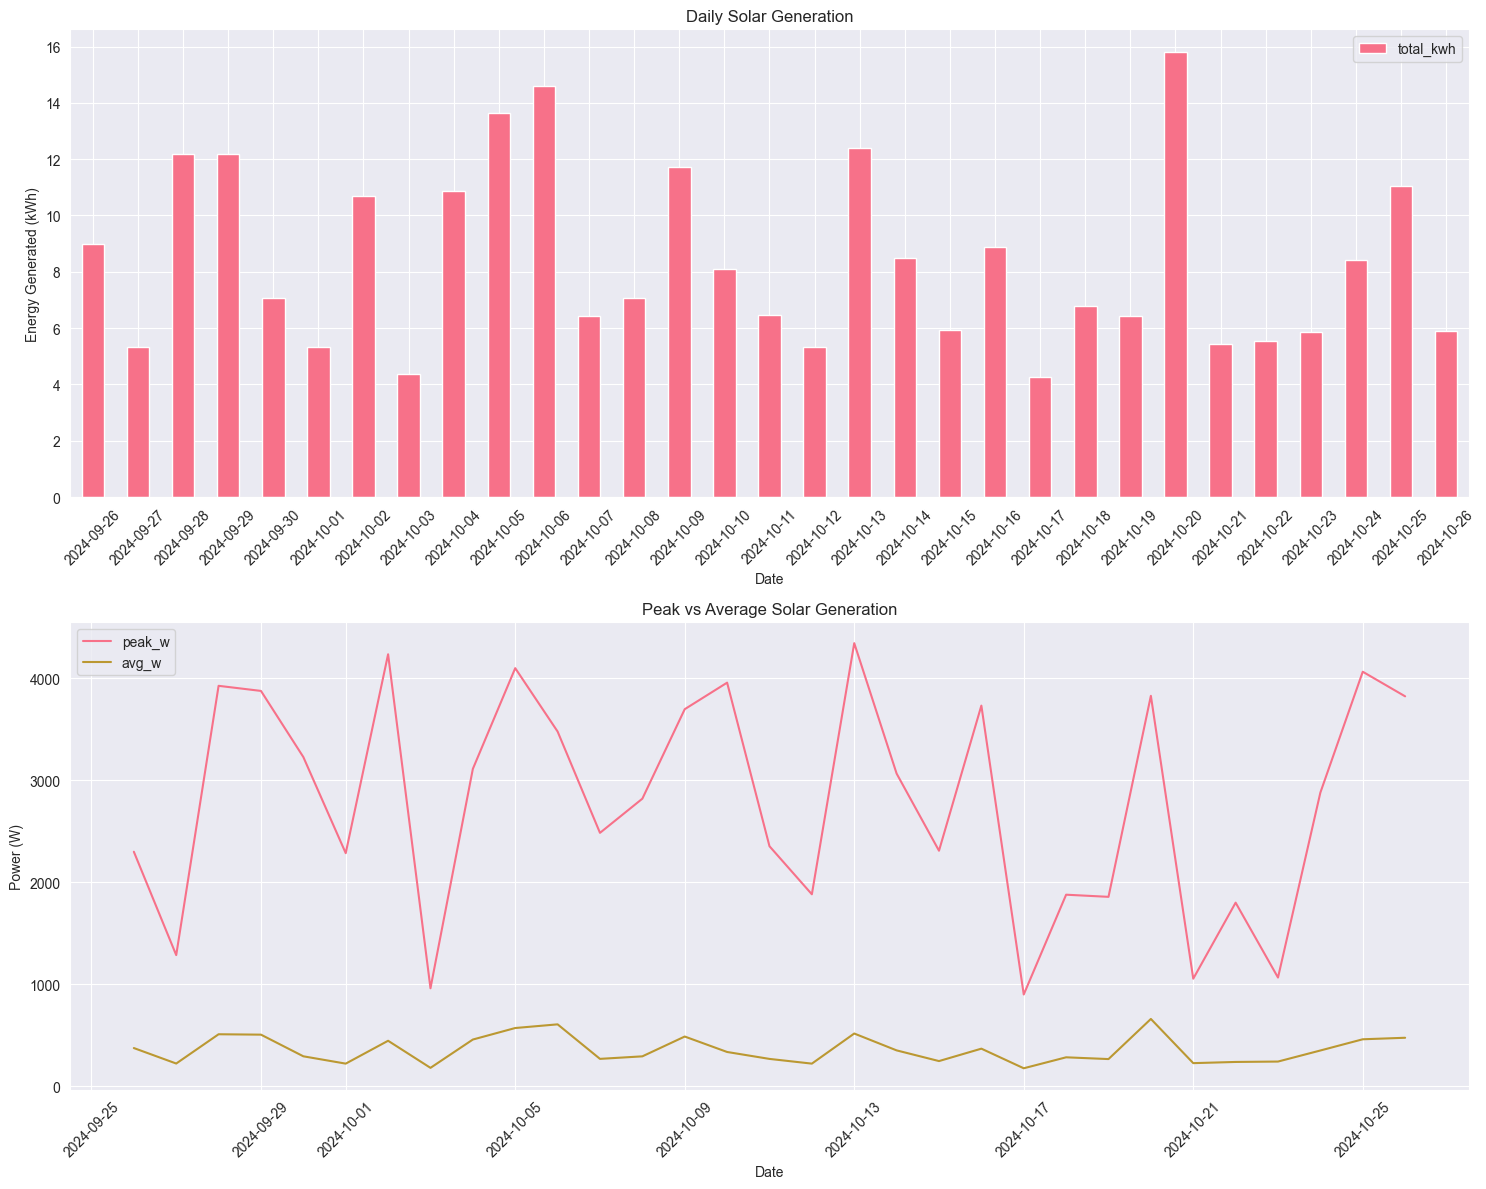

In [266]:
# 3. Solar Generation Analysis
solar_stats = analyze_solar_generation(df)
solar_plot = plot_solar_analysis(solar_stats)
plt.show()

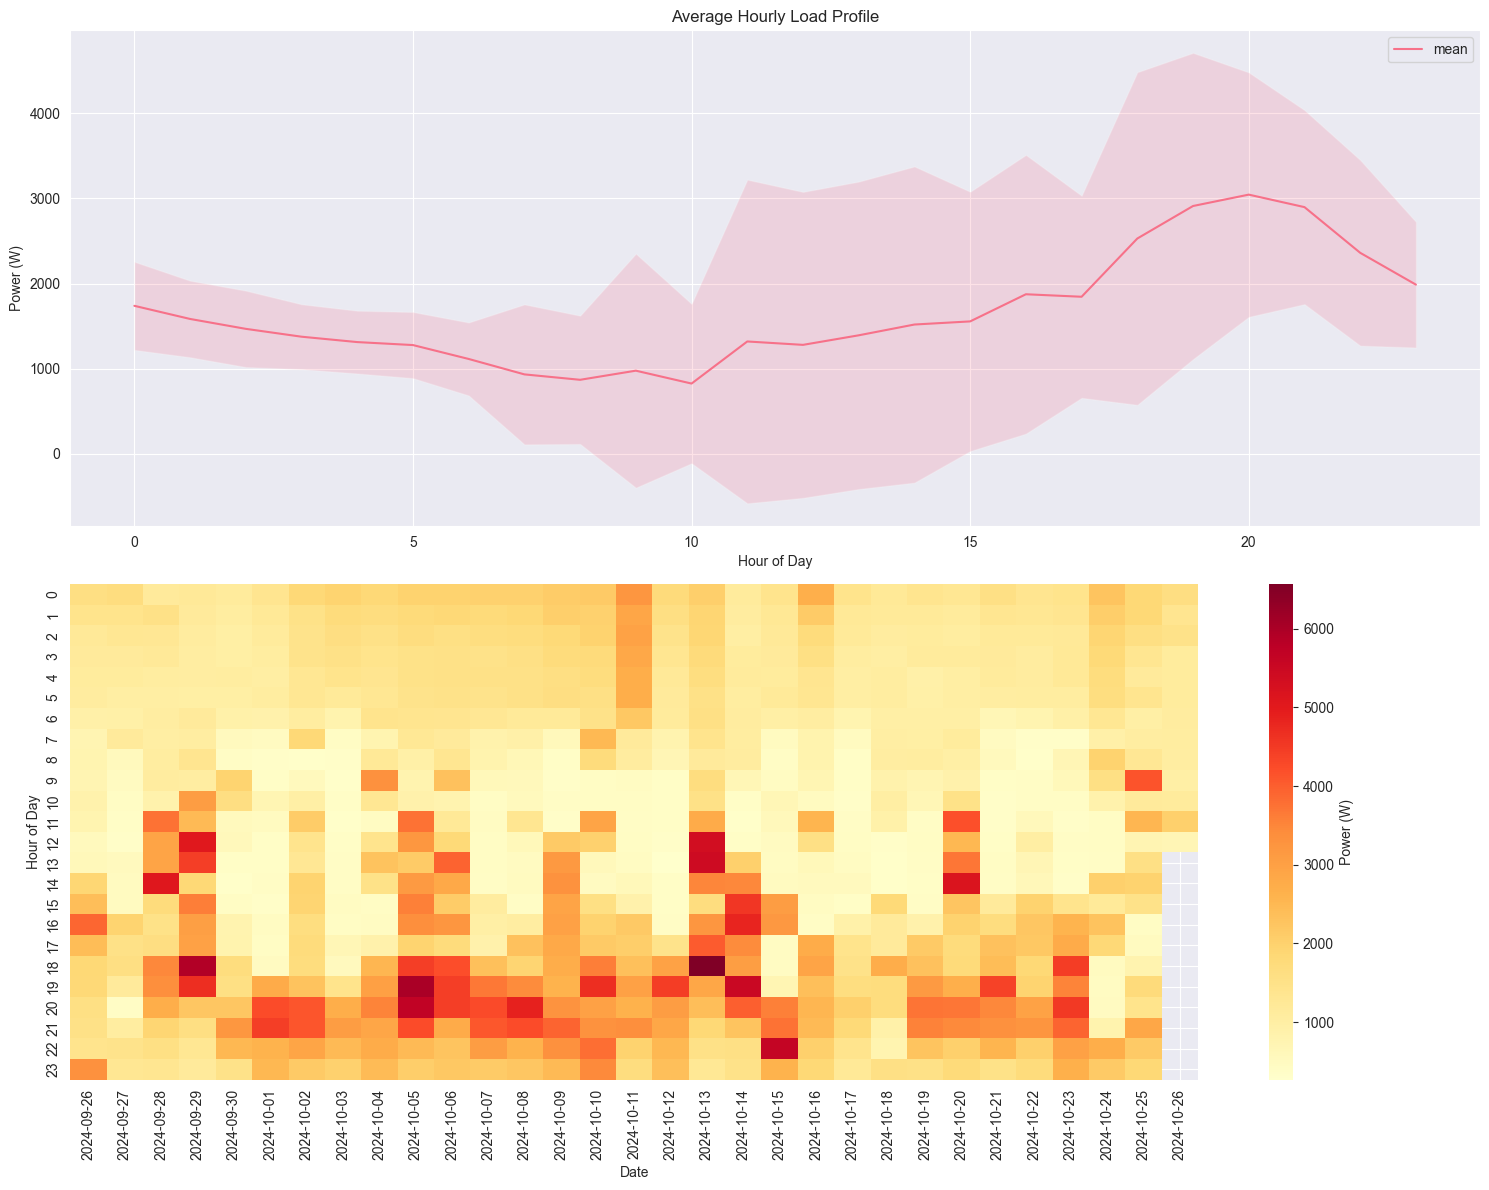

In [267]:
# 4. Load Profile Analysis
hourly_avg, daily_patterns = analyze_load_profile(df)
load_plot = plot_load_profile(hourly_avg, daily_patterns)
plt.show()

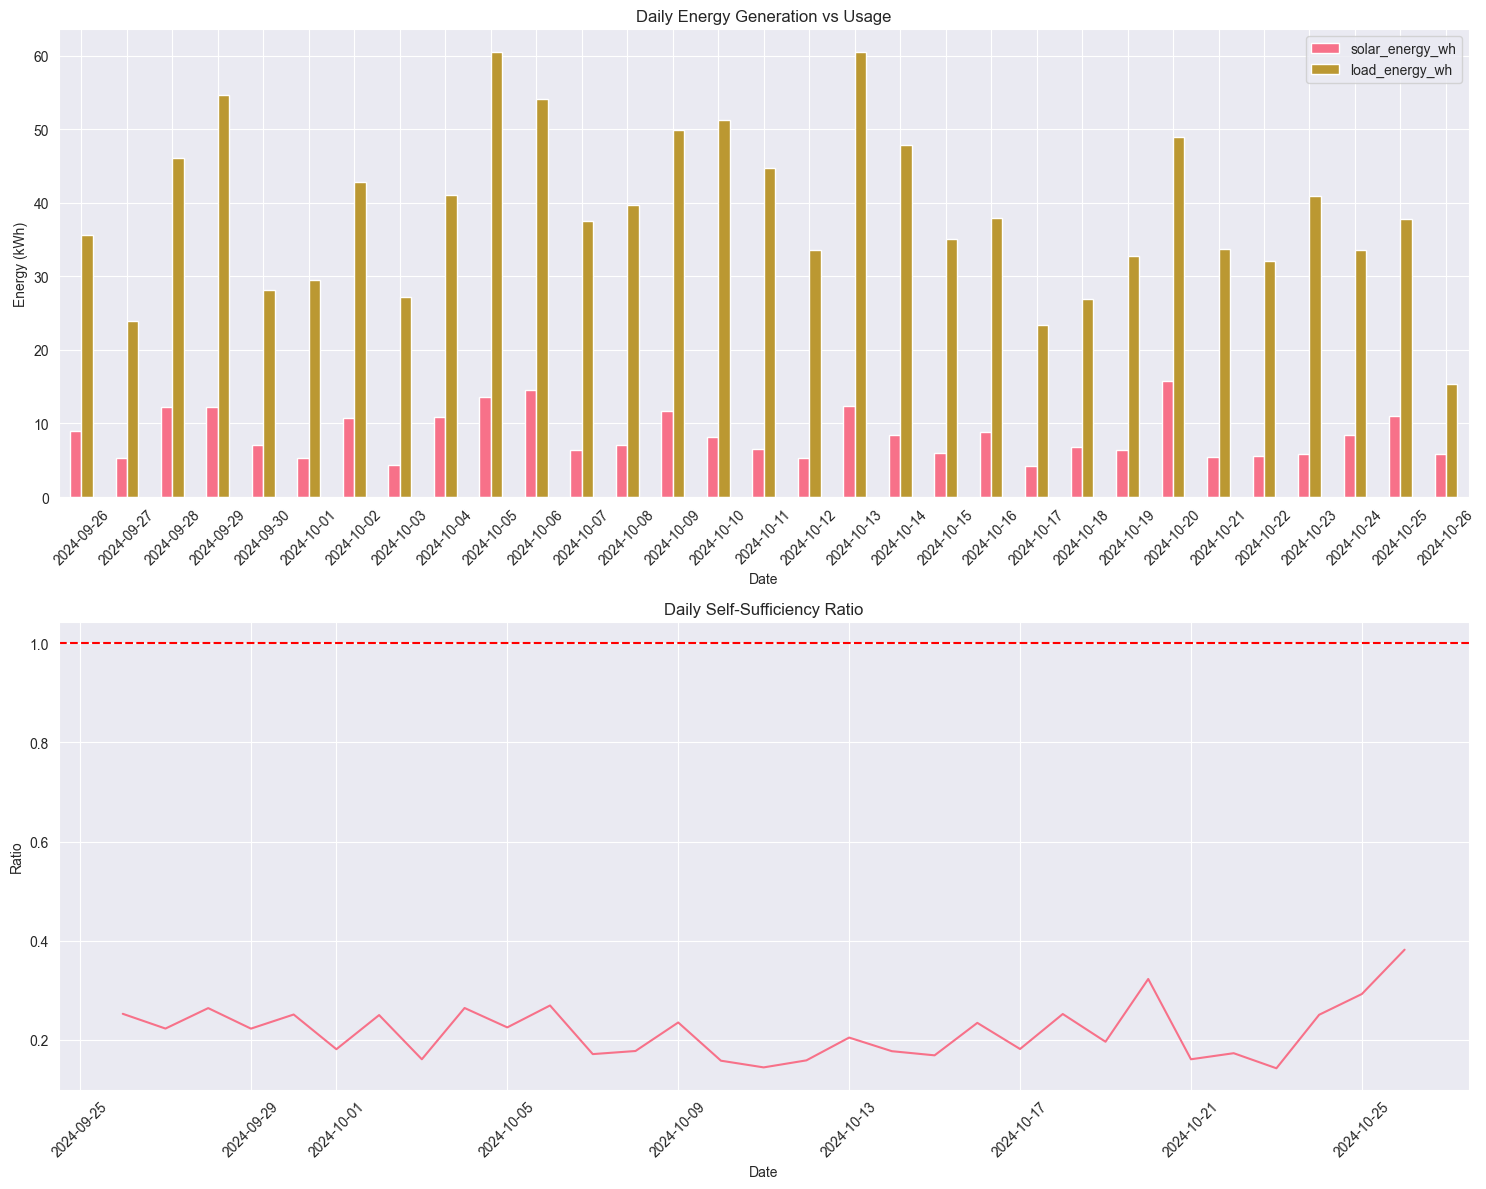

In [268]:
# 5. Self-Sufficiency Analysis
self_sufficiency = analyze_self_sufficiency(df)
sufficiency_plot = plot_self_sufficiency(self_sufficiency)
plt.show()


Battery Capacity Analysis:
Average Daily Load: 39.98 kWh
Recommended Capacity: 24.99 kWh

Economic Analysis:
Battery Cost: $3,408.14
Annual Grid Cost: $4,009.16
Simple Payback: 0.9 years


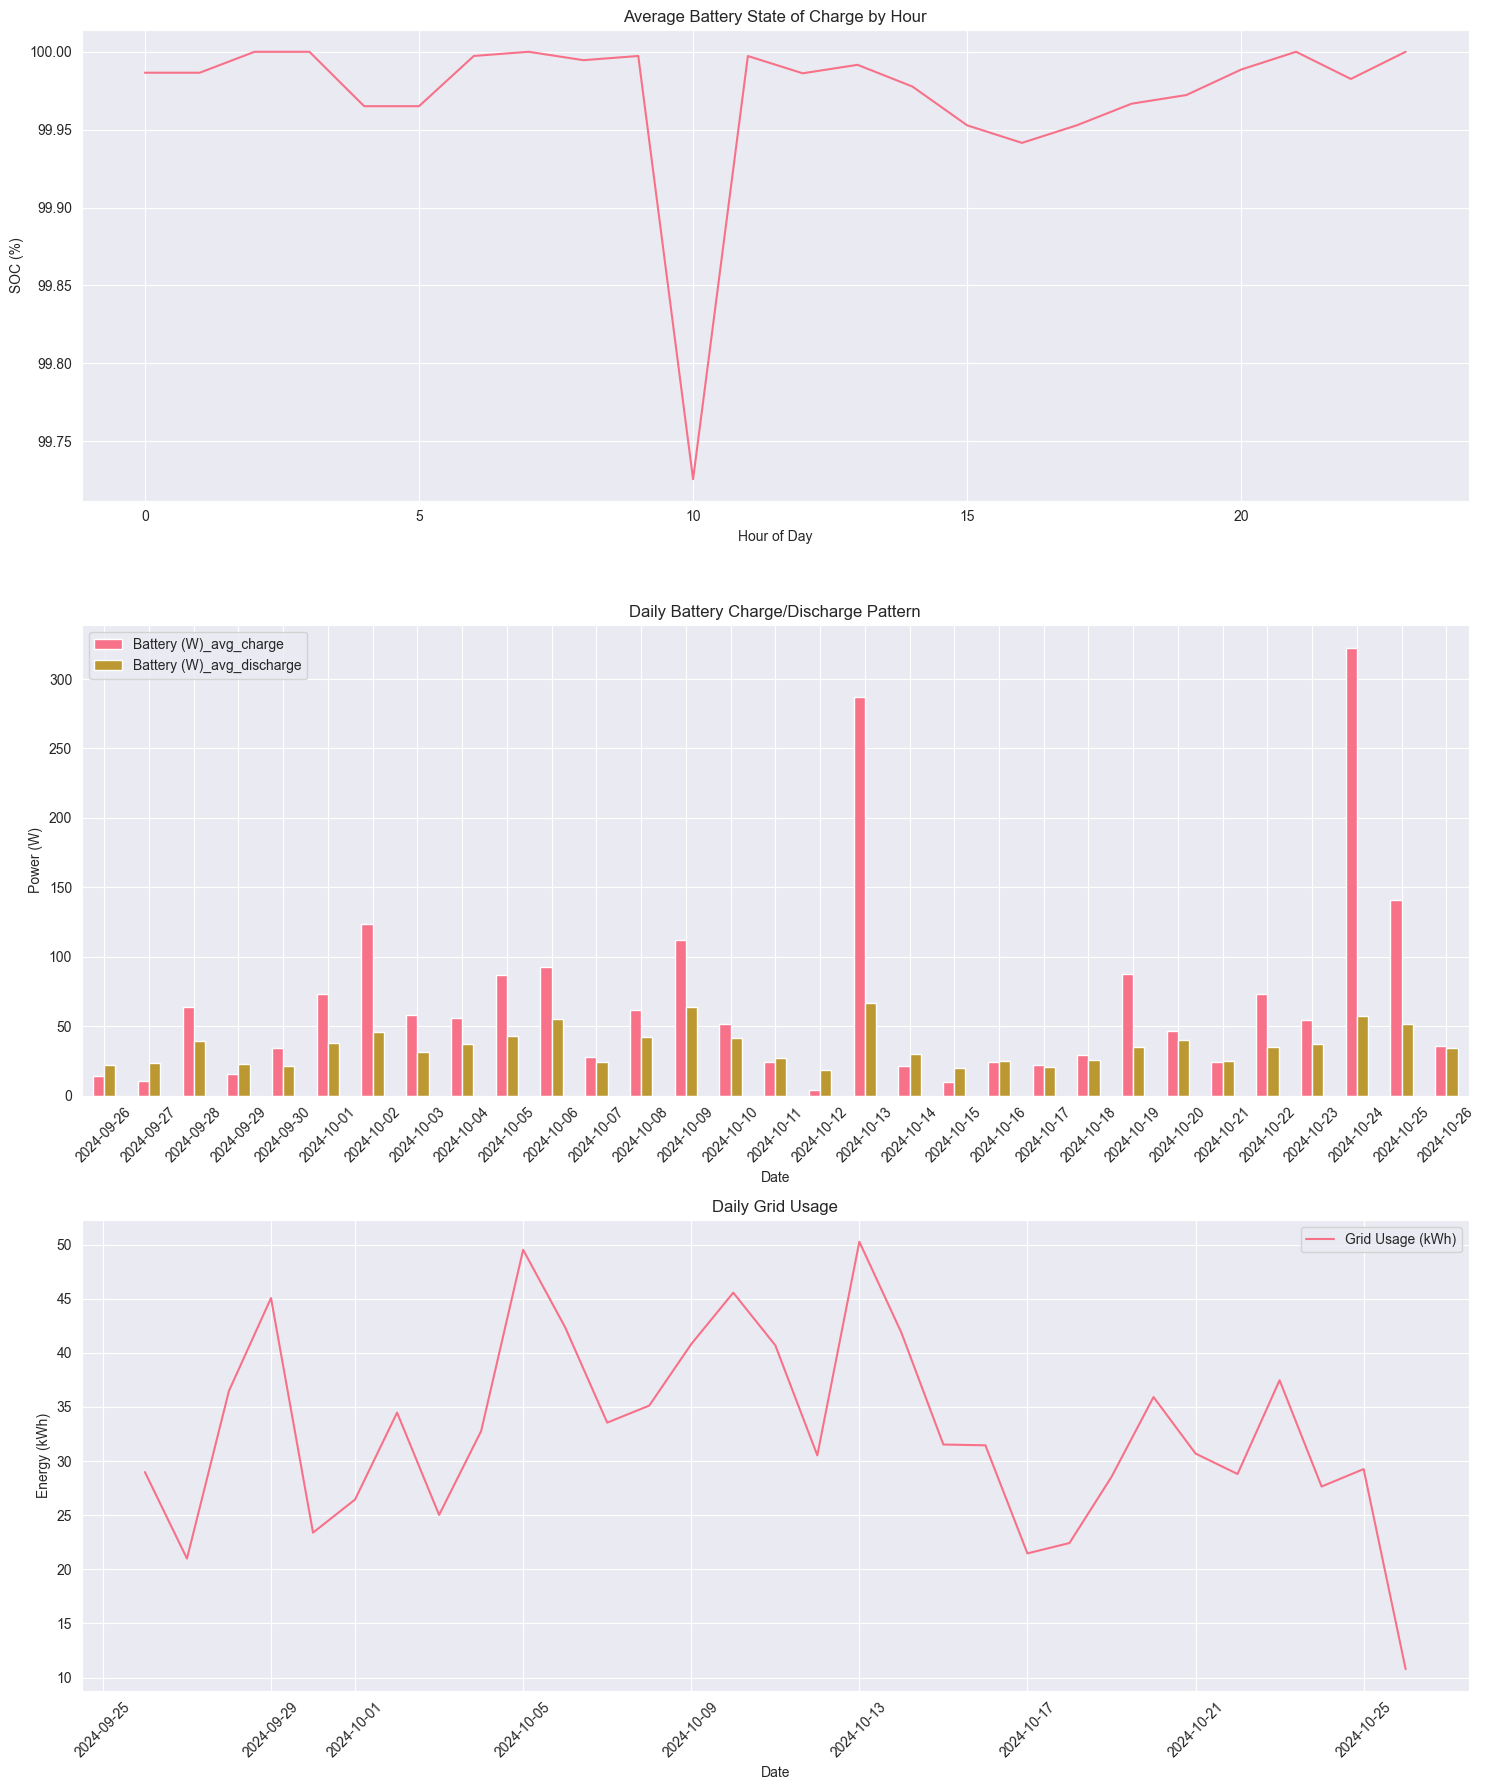

In [273]:
# Basic battery performance analysis
battery_metrics = analyze_battery_performance(df)
daily_deficit = analyze_battery_deficit(df)
    
# Calculate optimal battery capacity for flat rate scenario
capacity_analysis = calculate_flat_rate_battery_capacity(
    df,
    backup_hours=12,  # Full day backup
    depth_of_discharge=0.8  # 80% DoD
)
print("\nBattery Capacity Analysis:")
print(f"Average Daily Load: {capacity_analysis['avg_daily_load_kwh']:.2f} kWh")
print(f"Recommended Capacity: {capacity_analysis['recommended_capacity_kwh']:.2f} kWh")

# Economic analysis (example with sample rates)
economics = analyze_solar_battery_economics(
    df,
    electricity_rate=0.36,  # $0.12 per kWh
    battery_cost_per_kwh=140,  # $800 per kWh of capacity
    battery_cycles=3500,
    backup_hours=12
)
print("\nEconomic Analysis:")
print(f"Battery Cost: ${economics['estimated_battery_cost']:,.2f}")
print(f"Annual Grid Cost: ${economics['annual_grid_cost']:,.2f}")
print(f"Simple Payback: {economics['simple_payback_years']:.1f} years")

# Create visualizations
plot_battery_analysis(df, battery_metrics, daily_deficit)
plt.show()


System Efficiency Metrics:
Average Solar Utilization: 21.65%
Average Grid Dependency: 84.74%
Solar Contribution: 21.67%


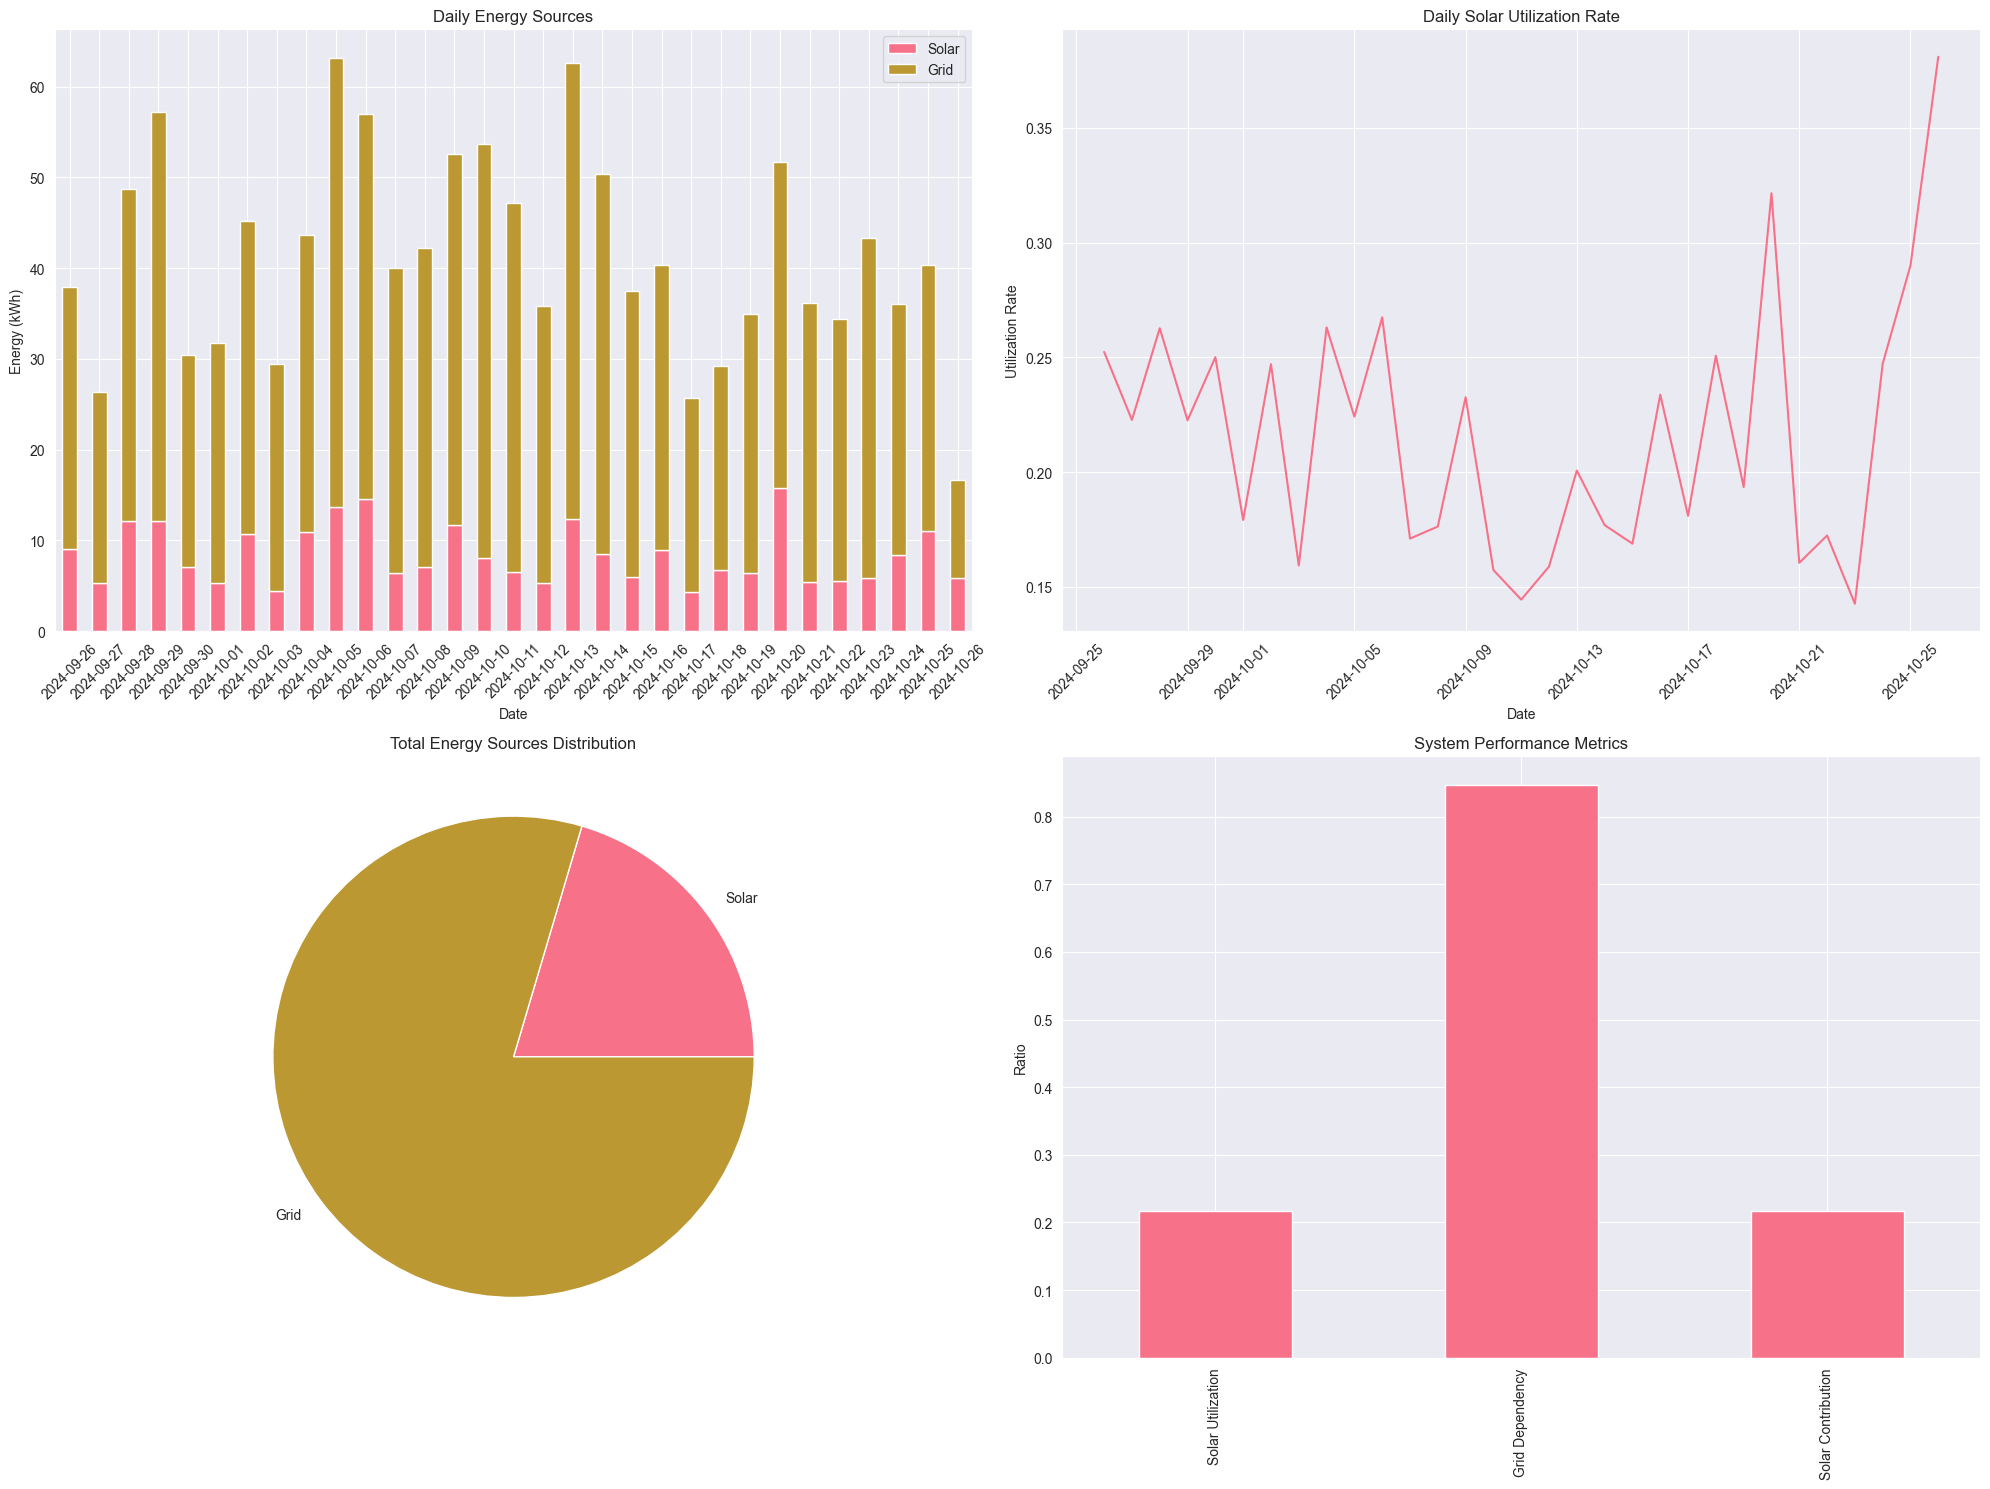

In [270]:
# Analyze system efficiency
daily_energy, system_metrics = analyze_system_efficiency(df)
efficiency_plot = plot_efficiency_analysis(daily_energy, system_metrics)
print("\nSystem Efficiency Metrics:")
print(f"Average Solar Utilization: {system_metrics['avg_solar_utilization']:.2%}")
print(f"Average Grid Dependency: {system_metrics['avg_grid_dependency']:.2%}")
print(f"Solar Contribution: {system_metrics['solar_contribution']:.2%}")